In [1]:
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import numpy.ma as ma
import pandas as pd
from time import time

import mne
from mne.datasets import sample
from mne.preprocessing import ICA

print(__doc__)
data_dir = 'data_meg'
subj = "R2488"
dataqual = 'prepro' #or loc/exp
exp = 'exp' #or exp
dtype = "raw"
label_dir = 'data_log'
save_dir = 'data_meg'
raw_path = f'{data_dir}/{subj}/{dataqual}/{subj}_{exp}.fif'
bad_channels_dict = {
    "R2490": ['MEG 014', 'MEG 004', 'MEG 079', 'MEG 072', 'MEG 070', 'MEG 080', 'MEG 074', 'MEG 067', 'MEG 082', 'MEG 105', 'MEG 115', 'MEG 141', 'MEG 153'],
    "R2488": ['MEG 015', 'MEG 014', 'MEG 068', 'MEG 079', 'MEG 146', 'MEG 147', 'MEG 007', 'MEG 141'],
    "R2487": ['MEG 015', 'MEG 014', 'MEG 068', 'MEG 079', 'MEG 147', 'MEG 146', 'MEG 004'],
    "R2280": ['MEG 024', 'MEG 039', 'MEG 079', 'MEG 077', 'MEG 141', 'MEG 073', 'MEG 075', 'MEG 076', 'MEG 064', 'MEG 063', 'MEG 060', 'MEG 059', 'MEG 058']
}
bad_channels = bad_channels_dict.get(subj, [])
raw = mne.io.read_raw_fif(raw_path).load_data()
reject = dict(mag=5e-12, grad=4000e-13)
raw.info['bads'].extend(bad_channels)
sfreq = raw.info['sfreq']
raw.filter(1, 30, method='iir')
downsample = 10
raw.resample(sfreq / downsample)
# raw_empty_room = mne.io.read_raw_fif(f'{data_dir}/{subj}/emptyroom/{subj}_emptyroom-{dtype}.fif', preload=True)
# raw_empty_room.info['bads'].extend(bad_channels)

Automatically created module for IPython interactive environment
Opening raw data file data_meg/R2488/prepro/R2488_exp.fif...


/var/folders/79/m99pb_8d67l3d79st4zhf4tc0000gn/T/ipykernel_31488/1198423704.py:29: RuntimeWarning: This filename (data_meg/R2488/prepro/R2488_exp.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(raw_path).load_data()


    Range : 0 ... 2779999 =      0.000 ...  2779.999 secs
Ready.
Opening raw data file /Users/dorisyu/meg_decoding/data_meg/R2488/prepro/R2488_exp-1.fif...
    Range : 2780000 ... 3309999 =   2780.000 ...  3309.999 secs
Ready.
Reading 0 ... 3309999  =      0.000 ...  3309.999 secs...
Filtering raw data in 2 contiguous segments
Setting up band-pass filter from 1 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 30.00 Hz: -6.02, -6.02 dB

4422 events found on stim channel STI 014
Event IDs: [160 161 162 163 164]
4422 events found on stim channel STI 014
Event IDs: [160 161 162 163 164]


<Raw | R2488_exp.fif, 193 x 331000 (3310.0 s), ~488.9 MB, data loaded>

Effective window size : 20.480 (s)
Plotting power spectral density (dB=True).


/Users/dorisyu/opt/anaconda3/envs/meg/lib/python3.9/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


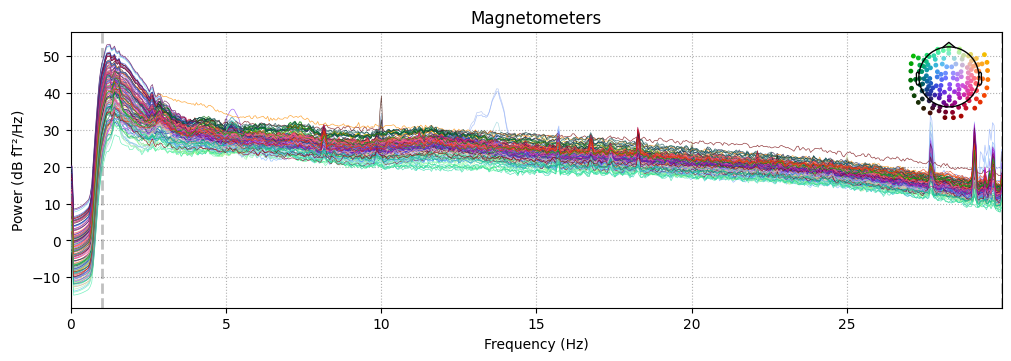

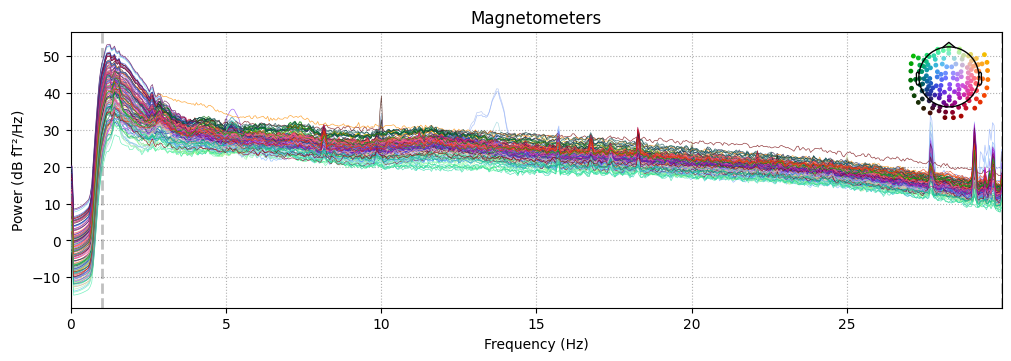

In [2]:
raw.compute_psd(fmax=30).plot(picks="data", exclude="bads", amplitude=False)

In [3]:
events = mne.find_events(raw, stim_channel='STI 014', output='onset', shortest_event=1)
event_id = {
    'start': 160,
    'move': 161,
    'reveal_red': 162,
    'reveal_white': 163,
    'done': 164,
    'choice': 165,
    'timeout': 166
}

# Define trials to remove
trials_to_remove = []
start_events = events[events[:, 2] == event_id['start']]
done_events = events[events[:, 2] == event_id['done']]
timeout_events = events[events[:, 2] == event_id['timeout']]
reveal_red_events = events[events[:, 2] == event_id['reveal_red']]
reveal_white_events = events[events[:, 2] == event_id['reveal_white']]
sfreq = raw.info['sfreq']  # Sampling frequency

# Combine 'done' and 'timeout' events
end_events = np.concatenate((done_events, timeout_events))
end_events = end_events[end_events[:, 0].argsort()] 

4422 events found on stim channel STI 014
Event IDs: [160 161 162 163 164]


In [4]:
filtered_start_events = [start_events[0]]  # Start with the first event

# Check for at least 3 seconds between each done event
for i in range(1, len(start_events)):
    time_diff = (start_events[i, 0] - start_events[i-1, 0]) / sfreq
    if time_diff < 2:
        print(f"Warning: Less than 3 seconds between done events at indices {i-1} and {i}")
    
    else:
        filtered_start_events.append(start_events[i])
start_events = filtered_start_events


In [5]:
# Initialize a list to store trial information
trial_info = []
previous_start_sample = None
processed_starts = set()
start_idx = 0
trail_t = 25
# Iterate through each start event to create trial information
for idx, start_event in enumerate(start_events):
    start_sample = start_event[0]
    
    # Find the next end event after the start event
    end_idx = np.searchsorted(end_events[:, 0], start_sample, side='right')
    end_sample = None
    while end_idx < len(end_events):
        potential_end_sample = end_events[end_idx, 0]
        if (potential_end_sample - start_sample) / sfreq <= trail_t:
            end_sample = potential_end_sample
            break
        end_idx += 1

    # If no valid end event is found, set end_sample to 26 seconds after start_sample
    if end_sample is None:
        end_sample = start_sample + int(trail_t * sfreq)
        

    # Check if the current start is at least 20 seconds after the previous start
    if (previous_start_sample is None or (start_sample - previous_start_sample) / sfreq >= 20) and start_sample not in processed_starts:
        # Proceed with processing this start event
        previous_start_sample = start_sample
        processed_starts.add(start_sample)  # Add to the set of processed starts

        # Calculate tmin and tmax for the epoch
        tmin = -0.2  # 0.2 s before 'start'
        tmax = trail_t  # Duration from 'start' to 1 s after end event
        reveal_red_within_trial = reveal_red_events[(reveal_red_events[:, 0] > start_sample) & 
                                                    (reveal_red_events[:, 0] < end_sample)]
        reveal_white_within_trial = reveal_white_events[(reveal_white_events[:, 0] > start_sample) & 
                                                        (reveal_white_events[:, 0] < end_sample)]
        # Store trial information, including whether 'reveal_red' and 'reveal_white' occurred
        trial_info.append({
            'event_sample': start_sample,
            'trial_index': start_idx,
            'duration': tmax,
            'tmin': tmin,
            'tmax': trail_t,
            'done': len(done_events) > 0,
            'start_times': start_sample / sfreq,
            'done_times': end_sample / sfreq,
            'end_sample': end_sample,
            'reveal_red': len(reveal_red_within_trial) > 0,  # Boolean flag indicating if 'reveal_red' occurred
            'reveal_red_times': (reveal_red_within_trial[:, 0] - start_sample) / sfreq if len(reveal_red_within_trial) > 0 else [],
            'reveal_white': len(reveal_white_within_trial) > 0,  # Boolean flag indicating if 'reveal_white' occurred
            'reveal_white_times': (reveal_white_within_trial[:, 0] - start_sample) / sfreq if len(reveal_white_within_trial) > 0 else [],
            'reveal_times': sorted(
                ((reveal_red_within_trial[:, 0] - start_sample) / sfreq).tolist() +
                ((reveal_white_within_trial[:, 0] - start_sample) / sfreq).tolist()
            )
        })
        start_idx += 1